# Skyscanner API Call

### Import modules
You can import more modules if needed

In [1]:
# first time (if you don´t have qgrid installed): run the commented code below in terminal to be able
# to make dataframes intuitive
#------------------
#pip install qgrid
#jupyter nbextension enable --py --sys-prefix qgrid
# only required if you have not enabled the ipywidgets nbextension yet
#jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [3]:
# Widgets
import qgrid

# Basic libraries
import numpy as np
import pandas as pd
import requests
import time
import datetime as dt
from bs4 import BeautifulSoup
import json
from datetime import timedelta
from datetime import datetime,timedelta
import seaborn as sns

# to auto-refresh the dashboard
#import operator as op
#import param
#import panel as pn
#import hvplot.pandas
#import hvplot.streamz
#import holoviews as hv
#from holoviews.element.tiles import EsriImagery
#from holoviews.selection import link_selections
#from datashader.utils import lnglat_to_meters
#from streamz.dataframe import PeriodicDataFrame

# Define useful functions

In [4]:
# print entire dataframe
def print_entire_df(df):
    '''prints entire table - for tables with many rows, use .head() instead'''
    qgrid_widget =  qgrid.show_grid(df,show_toolbar = True)
    return qgrid_widget

def graph_gridpoint_consulting(dataframe):
    '''For a particular date this graph shows price for different airlines and destinations'''
    sns.set(style="ticks")
    sns.set_style("darkgrid")
    sns.catplot(x="min_price", y="route", jitter=False,orient='h', data=dataframe,hue='airline',
            ) #order=['ACE','MAH','BIO','TFS','IBZ','ALC','AGP','PMI','VLC','SVQ','BCN','MAD']
    
    
def df_append(df1,df2):
    df_appended = df1.append(df2)
    return df_appended

def graph_daily_price(df,title):
    g = sns.FacetGrid(df, row='retrieval_time', hue='airline',height=4, aspect=3)
    g = g.map(sns.lineplot, 'dep_dt', 'min_price',dashes = False, marker = 'o',ci = None).add_legend()
    g.fig.suptitle( 'destination: ' + str(title),y=1.05 )


# Request data

The aim of this section is to extract Skyscanner flight prices for a particular destination (both directions included) and date range. The user will need to input the first and last date of the period manually following the indications below.

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:lightblue;font-family:Verdana,sans-serif;font-size:16px;">

<font size="5">Input first departure date (yyyy-mm-dd):</font>

</ol>
</div>

In [5]:
first_dep_date = input()

2021-08-01


<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:lightblue;font-family:Verdana,sans-serif;font-size:16px;">

<font size="5">Input last departure date (yyyy-mm-dd):</font>

</ol>
</div>

In [6]:
last_dep_date = input()

2021-08-03


In [7]:
# convert dates to datetime to find the difference between them (in days)
first_dep_date = pd.to_datetime(first_dep_date)
last_dep_date = pd.to_datetime(last_dep_date)
delta = last_dep_date-first_dep_date
delta = delta.days

# initializing a list that will be populated with departure dates
dep_dates = [0 for i in range(delta+1)] 

# populate the list for departure dates
for i in range(delta+1):
    date = first_dep_date+timedelta(days=i)
    dep_dates[i] = date.strftime("%Y-%m-%d")

# initializing a list that will be populated with return dates
rtn_dates = [0 for i in range(delta+1)] 

# populate the list for return dates
for i in range(delta+1):
    date = first_dep_date+timedelta(days=7+i)
    rtn_dates[i] = date.strftime("%Y-%m-%d")

In [8]:
# modify destination and dates according to the purpose of your request

origin_code = ['LHR','LGW','STN','LTN']
destination_code = ['BCN']
balearics = ['PMI','IBZ','MAH']
spain_mainland = ['BCN','BIO','ALC','AGP','VLC','SVQ','MAD']
spain = ['BCN','BIO','ALC','AGP','VLC','SVQ','MAD','PMI','IBZ','MAH','LPA','TFS','ACE']
canary_islands = ['LPA','TFS','ACE']
spain_islands = ['PMI','IBZ','MAH','LPA','TFS','ACE']
green_list_example = ['FAO','LIS','OPO','FNC']

trial = ['MAH','ALC','RHO','MLA','BIA','PUY','SKG','BER','JMK']

trial_mpd = ['MAH','BIA','PUY','SKG','BER','JMK']

trial1 = ['ALC','RHO','MLA']

In [9]:
def oneway(dep_stn_cd, arr_stn_cd, dep_dt, rtn_dt):
    '''function used to get ONEWAY prices from skyscanner through an API call. To do so, our key had to be input'''
    
    #inititalizing response and url
    response = {} # initialize a dictionary
    url = {} # initialize a dictionary
    
    l = 0 # counter that will increase as the number of requests increases
    t_start_iter = time.time() # time start
    
    print("********\n")
    print("time = ",datetime.now(),"\n\n")
    
    for i in range(len(dep_stn_cd)): # loop through dep_stn_cd
        
        for j in range(len(arr_stn_cd)): # loop through arr_stn_cd

            for k in range(len(dep_dt)): # loop through dep_dt
        
                print("i =",i)
                print("j =",j)
                print("k =",k)
                print("l = ",l)
                print(dep_stn_cd[i], " & ",arr_stn_cd[j]," & ",dep_dt[k])
                
                if l % 50 == 49: # if we are reaching the fifthiest iteration, wait until it´s been a minute due to API rate limit
                    count = 0
                    while True and count < 1: # loop while time between time start and 15 seconds and only one time iter
                        time.sleep(0.25) # sleep for 250 milliseconds
                        if time.time() >= t_start_iter + 120:
                            print("Start new iteration now" )
                            print("Time_start_iter = ",datetime.now(),"\n")
                            t_start_iter = time.time()
                            print("#_iter = ", count,"\n")
                            count = count + 1
                
                
                url[l] = "https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/" \
                "apiservices/browsequotes/v1.0/GB/GBP/en-GB/" + dep_stn_cd[i] \
                + "-sky/" + arr_stn_cd[j] \
                + "-sky/" + dep_dt[k]

                print(url[l])
                print("Time_start_iter = ",datetime.now(),"\n")

                querystring = {"inboundpartialdate":rtn_dt[k]}

                headers = {
                    # insert api key in the line below. e.g. "my_api_key"
                    'x-rapidapi-key': "xxxxxxxxxxx",
                    'x-rapidapi-host': "skyscanner-skyscanner-flight-search-v1.p.rapidapi.com"
                }

                response[l] = requests.request("GET", url[l], headers=headers, params=querystring)
                l = l+1
    return response

In [10]:
def rt7dstay(dep_stn_cd, arr_stn_cd, dep_dt, rtn_dt):
    '''function used to get RT (with 7 days between outbound and inbound flights) from skyscanner through an API call. 
    To do so, our key had to be input'''
    
    #inititalizing response and url
    response = {} # initialize a dictionary
    url = {} # initialize a dictionary
    
    l = 0 # counter that will increase as the number of requests increases
    t_start_iter = time.time() # time start
    
    print("********\n")
    print("time = ",datetime.now(),"\n\n")
    
    for i in range(len(dep_stn_cd)): # loop through dep_stn_cd
        
        for j in range(len(arr_stn_cd)): # loop through arr_stn_cd

            for k in range(len(dep_dt)): # loop through dep_dt
        
                print("i =",i)
                print("j =",j)
                print("k =",k)
                print("l = ",l)
                print(dep_stn_cd[i], " & ",arr_stn_cd[j]," & ",dep_dt[k])
                t_current_iter = time.time() # time start of current iteration
                
                if l % 50 == 49: # if we are reaching the fifthiest iteration, wait until it´s been a minute due to API rate limit
                    count = 0
                   
                    print("Time_current_iter = ",datetime.now(),"\n")
                    
                    while True and count < 1: # loop while time between time start and 15 seconds and only one time iter
                        time.sleep(0.25) # sleep for 250 milliseconds
                        
                        
                        
                        if time.time() >= t_current_iter + 90:
                            print("Start new iteration now" )
                            print("Time_start_iter = ",datetime.now(),"\n")
                            #t_start_iter = time.time()
                            print("#_iter = ", count,"\n")
                            count = count + 1
                
                
                url[l] = "https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/" \
                "apiservices/browsequotes/v1.0/GB/GBP/en-GB/" + dep_stn_cd[i] \
                + "-sky/" + arr_stn_cd[j] \
                + "-sky/" + dep_dt[k] \
                + "-sky/" + rtn_dt[k]
                
                print(url[l])
                print("Time_start_iter = ",datetime.now(),"\n")

                #querystring = {"inboundpartialdate":rtn_dt[k]}

                headers = {
                    # insert api key in the line below. e.g. "my_api_key"
                    'x-rapidapi-key': "xxxxxxxxxxx",
                    'x-rapidapi-host': "skyscanner-skyscanner-flight-search-v1.p.rapidapi.com"
                }

                response[l] = requests.request("GET", url[l], headers=headers) #params=querystring
                l = l+1
    return response

In [11]:
def create_dataframe(oneway_rt7dstay_ind,dep_stn_cd, arr_stn_cd, dep_dt, rtn_dt):
    
    
    response = oneway_rt7dstay_ind(dep_stn_cd, arr_stn_cd, dep_dt, rtn_dt) # GET request API call

    response_json = {} # initialize a dictionary that will be used to create the .json code (useful to get meaningful data)

    data = [[] for i in range(len(dep_stn_cd)*len(arr_stn_cd)*len(dep_dt))] # initialize a list that will be used to create a dataframe

    i = 0 # initialize dep_stn_cd counter
    j = 0 # initialize arr_stn_cd counter
    k = 0 # initialize dep_dt counter
    
    #t_start_iter = time.time() # time start

    for l in range(len(dep_stn_cd)*len(arr_stn_cd)*len(dep_dt)): # loop through list 
        print("i =", i)
        print("j =", j)
        print("k =", k)
        print("l =", l)
        print("Time_iter = ",datetime.now())
        
        if k == len(dep_dt): # if statement to deal with dep_dt
            j = j+1 # increase arr_stn_cd counter by 1
            print("j =", j)
            
            if j == len(arr_stn_cd): # if statement to deal with arr_stn_cd
                i = i+1  # increase dep_stn_cd counter by 1
                j = 0 # re-initialize arr_stn_cd counter
                print("i =", i)
                print("j =", j)
                
            k = 0 # re-initialize dep_dtdep_dates counter
            print("k =", k)

        print(dep_stn_cd[i], " & " ,arr_stn_cd[j], " & " ,dep_dt[k], " & " ,rtn_dt[k])

        response_json[l] = response[l].json() # json code for a dep_stn_cd, arr_stn_cd,dep_dt and rtn_dt

        print(response_json[l],"\n")
        
        if response_json[l]['Quotes']:
                if response_json[l]['Quotes'][0]['Direct'] == True:
                    print(response_json[l]['Places'][1]['CityId'][:3],"\n")
                    dep_city_cd = response_json[l]['Places'][1]['CityId'][:3] # saving the dep_city
                    data[l].append(response_json[l]['Places'][1]['CityId'][:3]) # dep_city_cd

                    print(response_json[l]['Places'][0]['CityId'][:3],"\n")
                    data[l].append(response_json[l]['Places'][0]['CityId'][:3]) # arr_city_cd

                    print(response_json[l]['Places'][1]['IataCode'],"\n")
                    data[l].append(response_json[l]['Places'][1]['IataCode']) # dep_stn_cd

                    print(response_json[l]['Places'][0]['IataCode'],"\n")
                    data[l].append(response_json[l]['Places'][0]['IataCode']) # arr_stn_cd

                    if dep_city_cd == 'LON': # route
                        data[l].append(response_json[l]['Places'][0]['IataCode']) # arr_stn_cd
                    else:
                        data[l].append(response_json[l]['Places'][1]['IataCode']) # dep_stn_cd

                    data[l].append(dep_dt[k])  #dep_dt
                    data[l].append(datetime.now().strftime("%d/%m/%Y %H:%M")) # retrieval time
                    if (response_json[l]['Carriers'][0]['Name'] =='Iberia') and (response_json[l]['Places'][0]['CityId'][:3] != 'MAD'):
                            data[l].append('British Airways')
                    else:
                            data[l].append(response_json[l]['Carriers'][0]['Name']) # airline
                    data[l].append(response_json[l]['Quotes'][0]['MinPrice']) # minimum price
                else:
                    print("len",len(response_json[l]['Carriers']))
                    if len(response_json[l]['Carriers']) > 1:
                        print(response_json[l]['Places'][1]['CityId'][:3],"\n")
                        dep_city_cd = response_json[l]['Places'][1]['CityId'][:3] # saving the dep_city
                        data[l].append(response_json[l]['Places'][1]['CityId'][:3]) # dep_city_cd

                        print(response_json[l]['Places'][0]['CityId'][:3],"\n")
                        data[l].append(response_json[l]['Places'][0]['CityId'][:3]) # arr_city_cd

                        print(response_json[l]['Places'][1]['IataCode'],"\n")
                        data[l].append(response_json[l]['Places'][1]['IataCode']) # dep_stn_cd

                        print(response_json[l]['Places'][0]['IataCode'],"\n")
                        data[l].append(response_json[l]['Places'][0]['IataCode']) # arr_stn_cd

                        if dep_city_cd == 'LON': # route
                            data[l].append(response_json[l]['Places'][0]['IataCode']) # arr_stn_cd
                        else:
                            data[l].append(response_json[l]['Places'][1]['IataCode']) # dep_stn_cd

                        data[l].append(dep_dt[k])  #dep_dt
                        data[l].append(datetime.now().strftime("%d/%m/%Y %H:%M")) # retrieval time
                        if (response_json[l]['Carriers'][1]['Name'] =='Iberia') and (response_json[l]['Places'][0]['CityId'][:3] != 'MAD'):
                            data[l].append('British Airways')
                        else:
                            data[l].append(response_json[l]['Carriers'][1]['Name']) # airline
                        data[l].append(response_json[l]['Quotes'][1]['MinPrice']) # minimum price
                    else:
                        data[l].append(None)
                        data[l].append(None)
                        data[l].append(None)
                        data[l].append(None)
                        data[l].append(None)
                        data[l].append(None)
                        data[l].append(datetime.now().strftime("%d/%m/%Y %H:%M")) # retrieval time
                        data[l].append(None)
                        data[l].append(None)
                        
        else:

            data[l].append(None)
            data[l].append(None)
            data[l].append(None)
            data[l].append(None)
            data[l].append(None)
            data[l].append(None)
            data[l].append(datetime.now().strftime("%d/%m/%Y %H:%M")) # retrieval time
            data[l].append(None)
            data[l].append(None)
            
        k = k+1 # increase dep_dt counter by 1

        print("\n")
        
    # list of lists approach of creating dataframes
    header=["dep_city_cd","arr_city_cd","dep_stn_cd", "arr_stn_cd", "route", "dep_dt","retrieval_time", "airline", "min_price"] # define the dataframe
    
    df = pd.DataFrame(data,columns=header)
    
    df = df.dropna() # drop rows with na
    
    df['dep_dt'] = pd.to_datetime(df['dep_dt']) # converting dates to type datetime
    df['dep_dt'] = df['dep_dt'].dt.date # converting dates in datetime format to type date
    #df['retrieval_time'] = dt.datetime.strptime(df['retrieval_time'], '%d/%m/%Y %H:%M') # converting dates to type date
    
    return df
        

In [12]:
#df OUTBOUND
df1 = create_dataframe(oneway,origin_code, trial1, dep_dates, rtn_dates)

********

time =  2021-07-23 18:53:00.250122 


i = 0
j = 0
k = 0
l =  0
LHR  &  ALC  &  2021-08-01
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/LHR-sky/ALC-sky/2021-08-01
Time_start_iter =  2021-07-23 18:53:00.250502 

i = 0
j = 0
k = 1
l =  1
LHR  &  ALC  &  2021-08-02
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/LHR-sky/ALC-sky/2021-08-02
Time_start_iter =  2021-07-23 18:53:01.248931 

i = 0
j = 0
k = 2
l =  2
LHR  &  ALC  &  2021-08-03
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/LHR-sky/ALC-sky/2021-08-03
Time_start_iter =  2021-07-23 18:53:01.494830 

i = 0
j = 1
k = 0
l =  3
LHR  &  RHO  &  2021-08-01
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/LHR-sky/RHO-sky/2021-08-01
Time_start_iter =  2021-07-23 18:53:01.737680 

i = 0
j = 1
k = 1
l =  4

i = 0
j = 0
k = 0
l = 0
Time_iter =  2021-07-23 18:53:10.519719
LHR  &  ALC  &  2021-08-01  &  2021-08-08
{'Quotes': [{'QuoteId': 1, 'MinPrice': 88, 'Direct': True, 'OutboundLeg': {'CarrierIds': [881], 'OriginId': 65698, 'DestinationId': 40531, 'DepartureDate': '2021-08-01T00:00:00'}, 'QuoteDateTime': '2021-07-23T15:16:00'}], 'Carriers': [{'CarrierId': 881, 'Name': 'British Airways'}], 'Places': [{'Name': 'Alicante', 'Type': 'Station', 'PlaceId': 40531, 'IataCode': 'ALC', 'SkyscannerCode': 'ALC', 'CityName': 'Alicante', 'CityId': 'ALIC', 'CountryName': 'Spain'}, {'Name': 'London Heathrow', 'Type': 'Station', 'PlaceId': 65698, 'IataCode': 'LHR', 'SkyscannerCode': 'LHR', 'CityName': 'London', 'CityId': 'LOND', 'CountryName': 'United Kingdom'}], 'Currencies': [{'Code': 'GBP', 'Symbol': '£', 'ThousandsSeparator': ',', 'DecimalSeparator': '.', 'SymbolOnLeft': True, 'SpaceBetweenAmountAndSymbol': False, 'RoundingCoefficient': 0, 'DecimalDigits': 2}]} 

LON 

ALI 

LHR 

ALC 



i = 0
j = 0
k

In [13]:
#df INBOUND
df2 = create_dataframe(oneway,trial1, origin_code, dep_dates, rtn_dates)

********

time =  2021-07-23 18:54:39.996592 


i = 0
j = 0
k = 0
l =  0
ALC  &  LHR  &  2021-08-01
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/ALC-sky/LHR-sky/2021-08-01
Time_start_iter =  2021-07-23 18:54:39.996885 

i = 0
j = 0
k = 1
l =  1
ALC  &  LHR  &  2021-08-02
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/ALC-sky/LHR-sky/2021-08-02
Time_start_iter =  2021-07-23 18:54:40.287913 

i = 0
j = 0
k = 2
l =  2
ALC  &  LHR  &  2021-08-03
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/ALC-sky/LHR-sky/2021-08-03
Time_start_iter =  2021-07-23 18:54:40.555648 

i = 0
j = 1
k = 0
l =  3
ALC  &  LGW  &  2021-08-01
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/ALC-sky/LGW-sky/2021-08-01
Time_start_iter =  2021-07-23 18:54:40.835780 

i = 0
j = 1
k = 1
l =  4

i = 2
j = 3
k = 2
l =  35
MLA  &  LTN  &  2021-08-03
https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/GB/GBP/en-GB/MLA-sky/LTN-sky/2021-08-03
Time_start_iter =  2021-07-23 18:54:49.240483 

i = 0
j = 0
k = 0
l = 0
Time_iter =  2021-07-23 18:54:49.484974
ALC  &  LHR  &  2021-08-01  &  2021-08-08
{'Quotes': [{'QuoteId': 1, 'MinPrice': 36, 'Direct': True, 'OutboundLeg': {'CarrierIds': [881], 'OriginId': 40531, 'DestinationId': 65698, 'DepartureDate': '2021-08-01T00:00:00'}, 'QuoteDateTime': '2021-07-23T15:16:00'}], 'Carriers': [{'CarrierId': 881, 'Name': 'British Airways'}], 'Places': [{'Name': 'Alicante', 'Type': 'Station', 'PlaceId': 40531, 'IataCode': 'ALC', 'SkyscannerCode': 'ALC', 'CityName': 'Alicante', 'CityId': 'ALIC', 'CountryName': 'Spain'}, {'Name': 'London Heathrow', 'Type': 'Station', 'PlaceId': 65698, 'IataCode': 'LHR', 'SkyscannerCode': 'LHR', 'CityName': 'London', 'CityId': 'LOND', 'CountryName': 'United Kingdom'}], 'Currencies': 

<br><br>
## Add direction

In [14]:
def add_direction_out(df):
    
    # add a column with all registers as OUT
    df['direction'] = 'OUT'
    
    columns = df.columns.to_list()
    columns = ['direction'] + columns[:-1]
    df = df.reindex(columns=columns)
    return df

In [15]:
def add_direction_inb(df):
    
    # add a column with all registers as OUT
    df['direction'] = 'INB'
    
    columns = df.columns.to_list()
    columns = ['direction'] + columns[:-1]
    df = df.reindex(columns=columns)
    return df

In [16]:
df1_dir = df1.copy()
df1_dir = add_direction_out(df1_dir)

In [17]:
df2_dir = df2.copy()
df2_dir = add_direction_inb(df2_dir)

<br><br>
## Append dataframes

In [19]:
# concatenate all dataframes
df_all = pd.concat([df1_dir,df2_dir],ignore_index=True)

In [20]:
df_all.shape

(55, 10)

In [21]:
df_all.head()

,direction,dep_city_cd,arr_city_cd,dep_stn_cd,arr_stn_cd,route,dep_dt,retrieval_time,airline,min_price
0,OUT,LON,ALI,LHR,ALC,ALC,2021-08-01,23/07/2021 18:53,British Airways,88.0
1,OUT,LON,ALI,LHR,ALC,ALC,2021-08-02,23/07/2021 18:53,British Airways,61.0
2,OUT,LON,ALI,LHR,ALC,ALC,2021-08-03,23/07/2021 18:53,British Airways,104.0
3,OUT,RHO,LON,RHO,LHR,RHO,2021-08-02,23/07/2021 18:53,British Airways,261.0
4,OUT,MLA,LON,MLA,LHR,MLA,2021-08-01,23/07/2021 18:53,Air Malta,98.0


<br><br>
## Visualise the data

In [22]:
print_entire_df(df_all)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

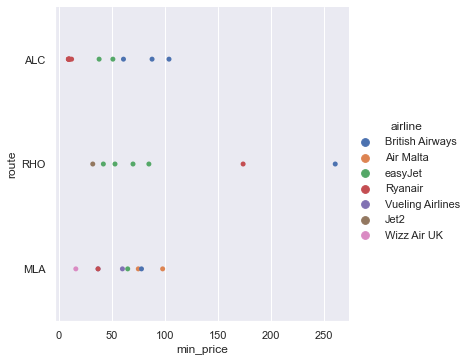

In [23]:
graph_gridpoint_consulting(df1)

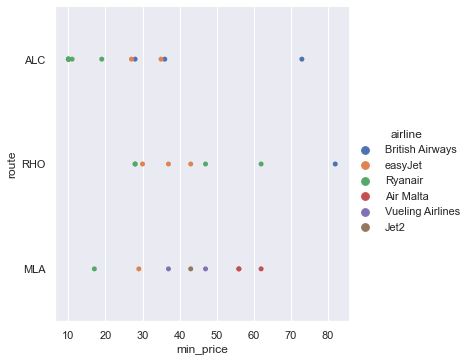

In [24]:
graph_gridpoint_consulting(df2)

In [25]:
def set_title(df):
    # put different destinations in a list to set title to the graphs
    df_route = set(df.route.to_list())
    df_route.discard(None)
    # convert it back to a list
    df_route = list(df_route)
    return df_route

In [27]:
df_route = set_title(df_all)
df_route

['MLA', 'RHO', 'ALC']

In [29]:
# visualise prices
def line_graph(df_title,df):
    for i in range( len(df_title) ):  
        df_aux = df[ df['route'] == df_title[i] ]
        graph_daily_price(df_aux,df_title[i])

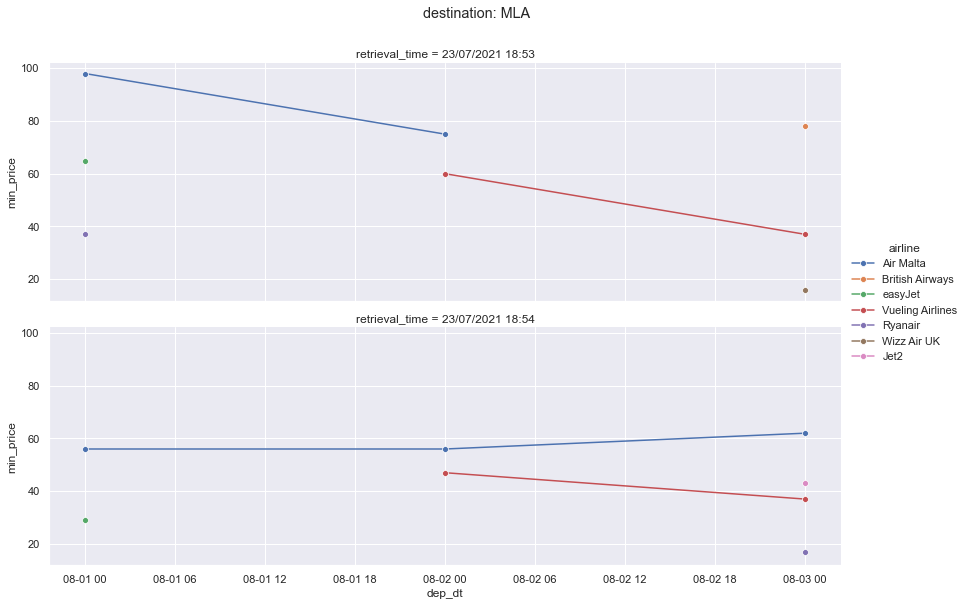

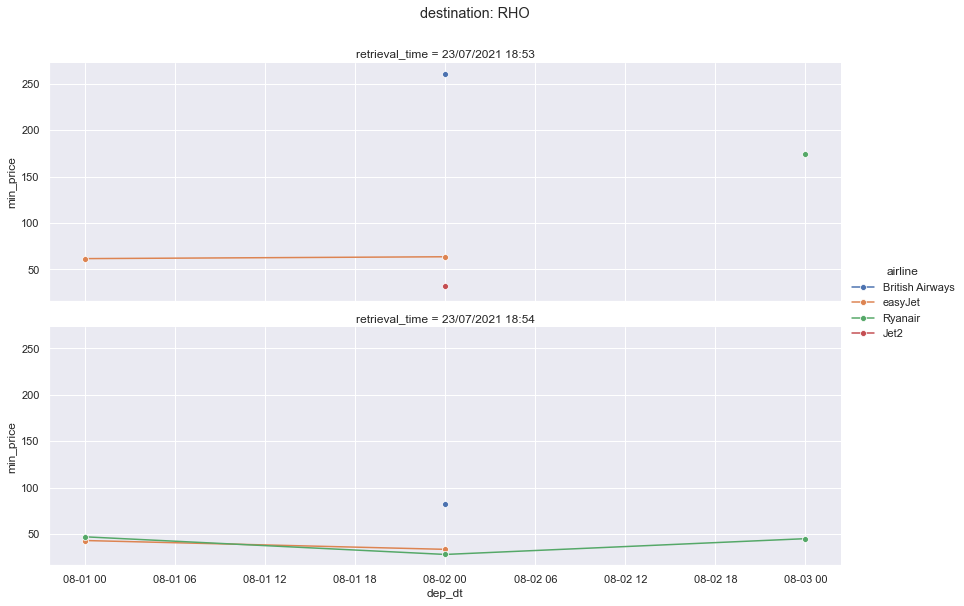

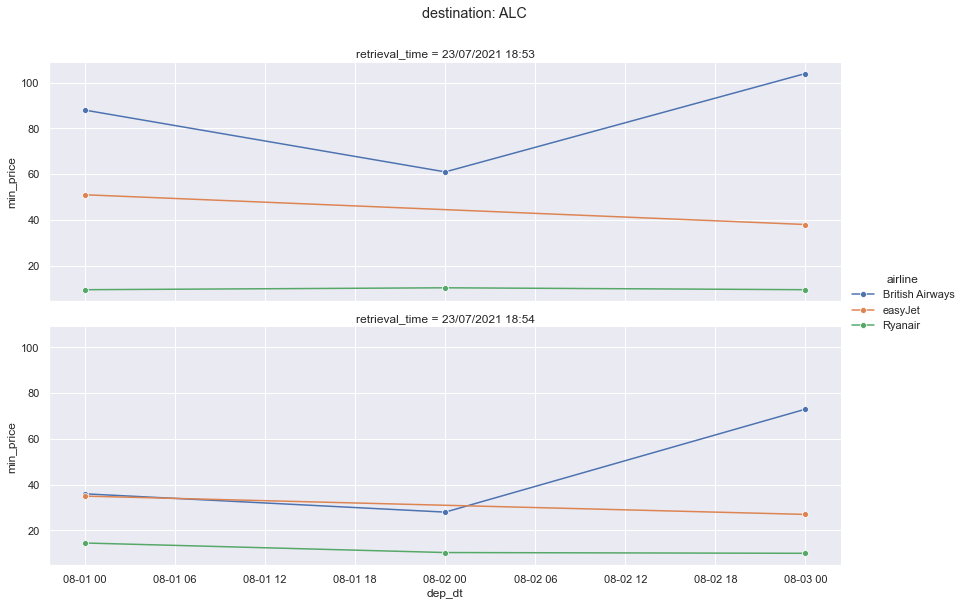

In [30]:
line_graph(df_route,df_all)